In [1]:
import os
import joblib
import urllib
import tarfile
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


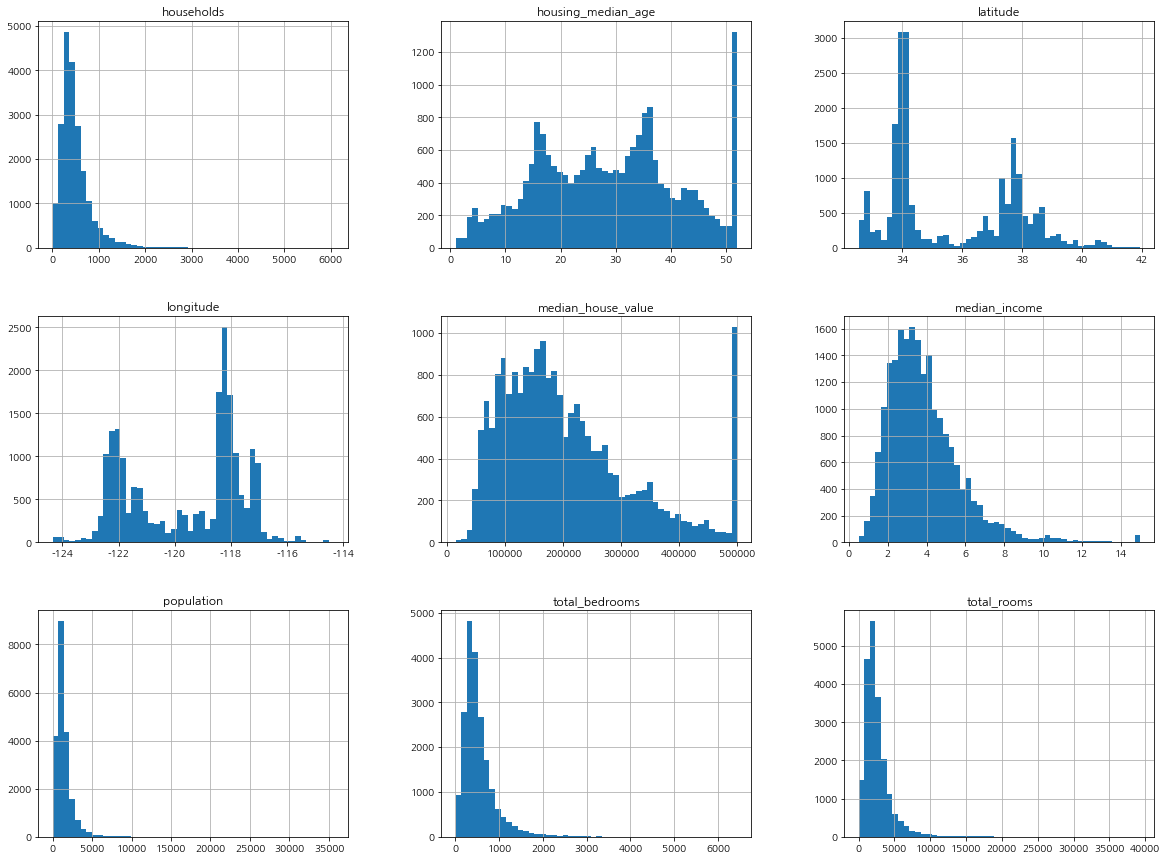

In [10]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

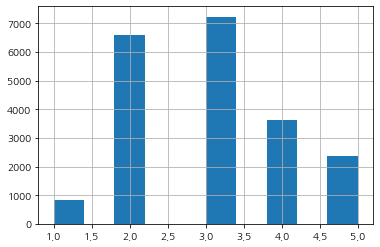

In [13]:
housing['income_cat'].hist()

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(['income_cat'], axis=1, inplace=True)

In [16]:
housing = strat_train_set.copy()

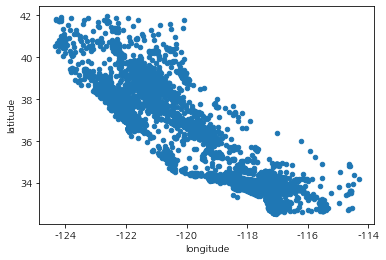

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude')

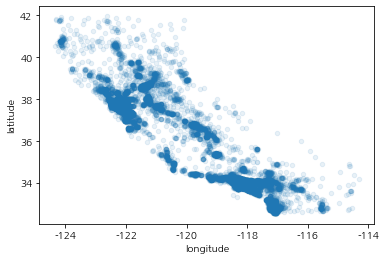

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

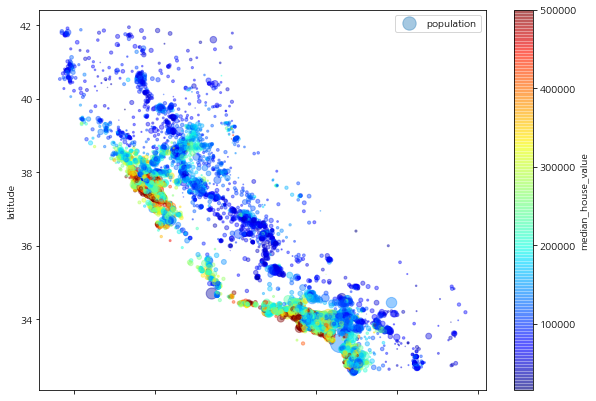

In [19]:
# s는 scatter plot에서 버블형태의 데이터의 크기를 나타낸다.(인구를 나타냄)
# c는 색상을 나타낸다.높을 수록 빨간색이고 낮을 수록 파란색이다.(가격을 나타냄)
# plt의 jet은 빨강~파랑 사이로 나타낸다.
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100,
             label='population', figsize=(10, 7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [20]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002653ADC5048>,
      dtype=object)

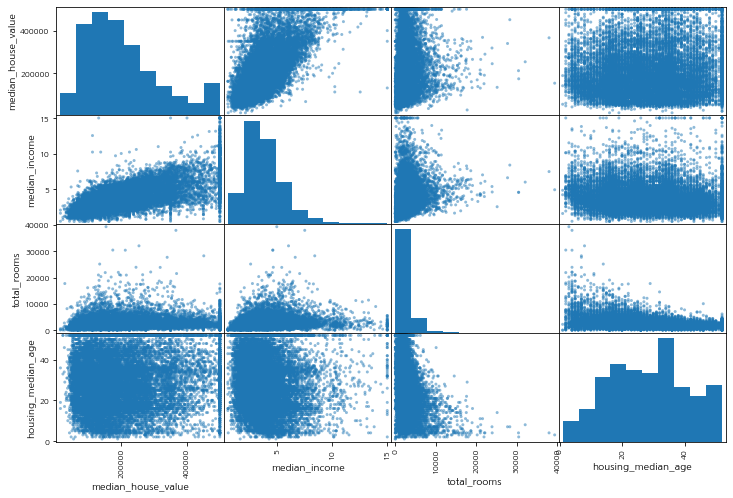

In [21]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

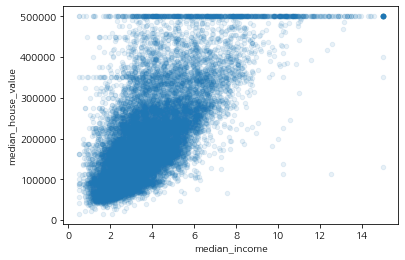

In [22]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [23]:
# 가구당 방 갯수
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
# 전체 방 중 침실의 비율
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
# 가구당 인원 수
housing['population_per_household'] = housing['population'] / housing['households']

In [24]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [25]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [26]:
housing.dropna(subset=['total_bedrooms'])
housing.drop('total_bedrooms', axis=1)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [27]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [28]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
x = imputer.transform(housing_num)

In [31]:
# 결측치 채운 후 데이터 프레임
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [32]:
# 텍스트와 범주형 특성 다루기
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [33]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [35]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
# 희소행렬 : 0이 아닌 원소의 위치만 저장한다. 메모리 관리에 효율적이다.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [38]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        rooms_per_household = x[:, rooms_ix] / x[:, households_ix]
        population_per_household = x[:, population_ix] / x[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = x[:, bedrooms_ix] / x[:, rooms_ix]
            return np.c_[x, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[x, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [39]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [40]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [41]:
# 수치형 변수는 앞선 num_pipeline을 통해 변환된다. 밀집 행렬로 표시
# 범주형 열은 OnHotEncoder를 사용해 변환된다. 희소 행렬로 표시
# ColumnTransformer는 하나의 변환기로 각 열마다 적절한 변환을 사용하여 모든 열을
# 처리할 수 있는 역할을 한다.
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [42]:
lr = LinearRegression()
lr.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('예측 : ', lr.predict(some_data_prepared))

예측 :  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [44]:
housing_predictions = lr.predict(housing_prepared)
lr_mse = mean_squared_error(housing_labels, housing_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_rmse

68628.19819848923

In [45]:
tree = DecisionTreeRegressor()
tree.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [46]:
housing_predictions = tree.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [47]:
scores = cross_val_score(tree, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [48]:
def display_scores(scores):
    print('점수 : ', scores)
    print('평균 : ', scores.mean())
    print('표준편차 : ', scores.std())

In [49]:
display_scores(tree_rmse_scores)

점수 :  [68949.46263733 67773.46528171 72654.43942429 69192.52360531
 71234.80790898 73894.10529845 72094.33434649 71702.37536675
 75527.61345354 70073.31969741]
평균 :  71309.64470202631
표준편차 :  2261.425901801111


In [50]:
lr_scores = cross_val_score(lr, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lr_rmse_scores = np.sqrt(-lr_scores)

In [51]:
display_scores(lr_rmse_scores)

점수 :  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균 :  69052.46136345083
표준편차 :  2731.6740017983475


In [52]:
rf = RandomForestRegressor()
rf.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [53]:
rf_scores = cross_val_score(rf, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

점수 :  [49794.69159128 47455.61709948 49641.09789579 52336.76869162
 49638.49821185 53261.44425021 48522.02803297 48417.64331845
 53107.15017835 50426.44582222]
평균 :  50260.13850922159
표준편차 :  1916.2674212921613


In [54]:
# 모델 저장하는 방법
# joblib.dump(my_model, 'my_model.pkl')

In [55]:
param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
]

In [56]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [57]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [58]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [59]:
cvres = grid_search.cv_results_

In [60]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64065.17381514377 {'max_features': 2, 'n_estimators': 3}
55735.074344237764 {'max_features': 2, 'n_estimators': 10}
53028.976111212134 {'max_features': 2, 'n_estimators': 30}
61889.90355224247 {'max_features': 4, 'n_estimators': 3}
52454.50500825664 {'max_features': 4, 'n_estimators': 10}
50711.407775031796 {'max_features': 4, 'n_estimators': 30}
59668.66986890249 {'max_features': 6, 'n_estimators': 3}
52344.63458665779 {'max_features': 6, 'n_estimators': 10}
49934.659174142784 {'max_features': 6, 'n_estimators': 30}
58926.1120227238 {'max_features': 8, 'n_estimators': 3}
51983.6438166673 {'max_features': 8, 'n_estimators': 10}
50232.93973541276 {'max_features': 8, 'n_estimators': 30}
62377.562960057294 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54909.41011558312 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60079.43153383105 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52849.08326937274 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.34822969e-02, 7.81124987e-02, 4.26413639e-02, 1.86568469e-02,
       1.70711184e-02, 1.75147991e-02, 1.62624343e-02, 2.96273432e-01,
       6.17238657e-02, 1.03419942e-01, 9.79364988e-02, 2.22465508e-02,
       1.31989846e-01, 5.96524584e-05, 4.66123473e-03, 7.94761863e-03])

In [62]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2962734322338156, 'median_income'),
 (0.1319898463890769, 'INLAND'),
 (0.10341994224214039, 'pop_per_hhold'),
 (0.09793649880283381, 'bedrooms_per_room'),
 (0.08348229691551076, 'longitude'),
 (0.07811249866030887, 'latitude'),
 (0.06172386566536061, 'rooms_per_hhold'),
 (0.04264136392672925, 'housing_median_age'),
 (0.022246550781378483, '<1H OCEAN'),
 (0.018656846855164597, 'total_rooms'),
 (0.017514799076116513, 'population'),
 (0.01707111835865778, 'total_bedrooms'),
 (0.016262434270120293, 'households'),
 (0.00794761863281827, 'NEAR OCEAN'),
 (0.004661234731598228, 'NEAR BAY'),
 (5.965245836977527e-05, 'ISLAND')]

In [63]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [64]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45186.97451233, 48977.27910937])